In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#为了在jupyter notebook里画图
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.0.0
sys.version_info(major=3, minor=6, micro=11, releaselevel='final', serial=0)
matplotlib 3.3.3
numpy 1.19.4
pandas 1.1.4
sklearn 0.23.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
#分类问题的数据集
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all),(x_test, y_test)=fashion_mnist.load_data()
#拆分训练集和验证集
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
print(np.max(x_train),np.min(x_train))

255 0


In [4]:
#归一化
#x = (x-u)/std
#减去均值除以方差进行归一化
from sklearn.preprocessing import StandardScaler
#x_train:三维矩阵[None,28,28]->[None, 784]
scaler = StandardScaler()
#训练集
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
#验证集和测试集做归一化时，需要使用训练集的方差做
#验证集直接transform，不用fit
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
#测试集
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

In [5]:
#tf.keras.models.Sequential()
#创建sequential对象
model = keras.models.Sequential()
#反复添加层数会使程序非常长，使用for循环进行重复定义的工作

#将输入做展平Flatten
model.add(keras.layers.Flatten(input_shape=[28,28]))

#添加20层神经网络
for _ in range(20):
    model.add(keras.layers.Dense(100,activation="relu"))
#输出等于类别数目10
model.add(keras.layers.Dense(10, activation="softmax"))

#relu: y = max(0, x)
#softmax: 将向量变成概率分布，x=[x1,x2,x3]
#y = [e^x1/sum,e^x2/sum,e^x3/sum],sum=e^x1+e^x2+e^x3

#reason for sparse:y->index,y->one_hot->[]
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",metrics=["accuracy"])
#损失函数用交叉熵误差
#如果y是一个向量，去掉sparse_.如果y是数，不用去掉；
#optimizer是调整方法，sgd是随机梯度下降法


In [6]:
model.summary()
#20层的神经网络

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [7]:
#添加callbacks数组，再将数组作为参数传入fit
#使用的callbacks：Tensorboard文件夹,earlystopping,ModelCheackpoint文件名
#logdir = './dnn-callbacks'
logdir = os.path.join("dnn-callbacks")
#修改路径避免污染之前的文件夹

#如果文件夹不存在，就创建一个
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, 
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                   save_best_only=True),
    #默认保存最好的模型，否则系统会保存最近的模型
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3),
]

#235500 = 784*300+300
#[None, 784] * W + b->[None, 300] W.shape[784,300],b = [300]
#b是偏置

#开始训练
history = model.fit(x_train_scaled, y_train, epochs=10, 
                    validation_data=(x_valid_scaled,y_valid),
                   callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 10s 186us/sample - loss: 1.9665 - accuracy: 0.2608 - val_loss: 1.0171 - val_accuracy: 0.6006
Epoch 2/10
55000/55000 [==============================] - 9s 156us/sample - loss: 0.7935 - accuracy: 0.6835 - val_loss: 0.8461 - val_accuracy: 0.6912
Epoch 3/10
55000/55000 [==============================] - 9s 157us/sample - loss: 0.5633 - accuracy: 0.7981 - val_loss: 0.5388 - val_accuracy: 0.8136
Epoch 4/10
55000/55000 [==============================] - 9s 162us/sample - loss: 0.4738 - accuracy: 0.8390 - val_loss: 0.4291 - val_accuracy: 0.8552
Epoch 5/10
55000/55000 [==============================] - 9s 163us/sample - loss: 0.4244 - accuracy: 0.8563 - val_loss: 0.4065 - val_accuracy: 0.8608
Epoch 6/10
55000/55000 [==============================] - 9s 156us/sample - loss: 0.3968 - accuracy: 0.8657 - val_loss: 0.4082 - val_accuracy: 0.8644
Epoch 7/10
55000/55000 [==========================

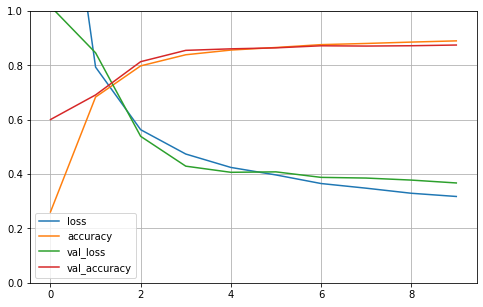

In [11]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_learning_curves(history)

In [9]:
#在测试集上测试
model.evaluate(x_test_scaled, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.39892184982299805, 0.864]